## Task 3: Predictive Analysis - WIP
Consider the problem of predicting for each incident (considering the whole dataset for this task) the label which is a **binary variable** that indicates if in the incident there have been at least a killed person or not.


In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py


# Set a seed for reproducibility
np.random.seed(42)



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import the datasets

# Gun incidents data
df_incidents_cleaned = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5', key = 'df')

# Visualize data table
df_incidents_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64   

In [3]:

df_incidents_dt = df_incidents_cleaned.copy()
#df_incidents_dt['n_participant_adult'] = (df_incidents_dt['n_participants'] - (df_incidents_dt['n_participants_child'] + df_incidents_dt['n_participants_teen'])).astype('int')


<AxesSubplot:title={'center':'Percentage of incidents with killed people'}, ylabel='isKilled'>

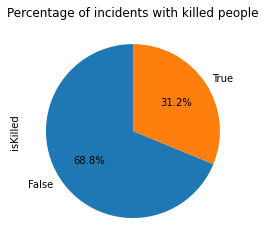

In [4]:
df_incidents_dt['isKilled'] = df_incidents_dt['n_killed'] > 0
df_incidents_dt['isKilled'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, title = 'Percentage of incidents with killed people')


In [5]:
coumns_not_to_drop_dt = ['isKilled', 'n_arrested', 'n_females',
                         'avg_age_participants', 
                         'density_incident_state', 'state', 'n_injured']

# broke all if you add n_killed since is higly correlated : 0.94

all_columns_dt = df_incidents_dt.columns

columns_to_drop_dt = [x for x in all_columns_dt if x not in coumns_not_to_drop_dt]

df_incidents_dt.drop(columns_to_drop_dt, axis = 1, inplace = True)
df_incidents_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   state                   131618 non-null  object 
 1   avg_age_participants    131618 non-null  int64  
 2   n_females               131618 non-null  int64  
 3   n_injured               131618 non-null  int64  
 4   n_arrested              131618 non-null  int64  
 5   density_incident_state  131618 non-null  float64
 6   isKilled                131618 non-null  bool   
dtypes: bool(1), float64(1), int64(4), object(1)
memory usage: 7.2+ MB


In [6]:

columns_to_drop_dt = ['longitude',
                   'latitude', 
                   'congressional_district',
                   'participant_age_group1',
                   'participant_gender1',
                   'incident_characteristics1',
                   'city_or_county',
                   'date',
                   'n_injured',
                   'party',
                   'candidatevotes',
                   'totalvotes',
                   'n_killed',
                   'ratio_killed'
                   ]


/tmp/ipykernel_55237/458054139.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



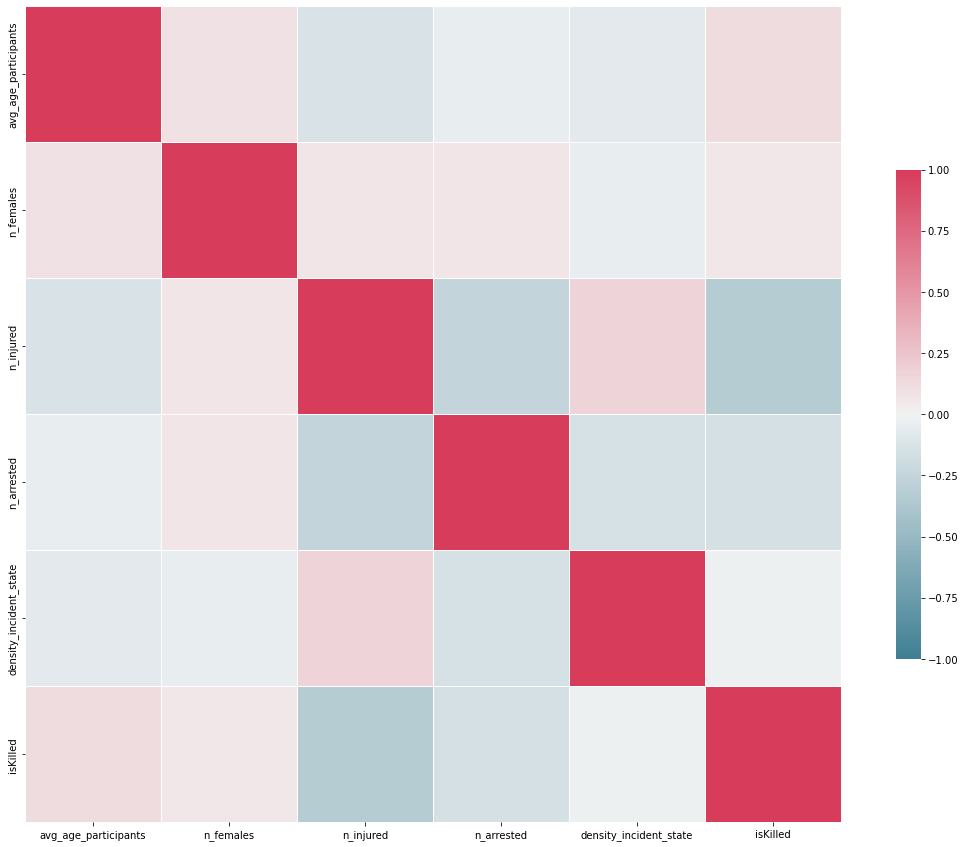

In [7]:
def plot_correlation(df_columns, df):
    
    # Compute the correlation matrix
    corr = df[df_columns].corr()

    # Generate a mask for the upper triangle
    #do not use np.bool is deprecated
    mask = np.zeros_like(corr, dtype=bool)
     
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 15))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 5, as_cmap=True)

    # Put numbers in squares that have correlation > 0.5 or < -0.5
    # Iterate over the correlation matrix and get the columns indices
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            if (corr.iloc[i, j] > 0.5 or corr.iloc[i, j] < -0.5) and i != j:
                # put text in square
                ax.text(j+0.5, i+0.5, '{:.2f}'.format(corr.iloc[i, j]), ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .6})
    
plot_correlation(df_incidents_dt.columns, df_incidents_dt)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Assuming df_incidents_cleaned is your original DataFrame

UMBALANCE_DATA = False

if not UMBALANCE_DATA:

    # Select 100 samples where isKilled is True
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=30000, random_state=42)
    
    killed_samples_small = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=7000, random_state=42)
    # Select 100 samples where isKilled is False
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=30000, random_state=42)
    
    not_killed_samples_small = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=7000, random_state=42)
else:
    
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=500, random_state=42)
    
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=3000, random_state=42) 


# Concatenate the balanced samples into a new DataFrame
balanced_df = pd.concat([killed_samples, not_killed_samples])
balanced_df_small = pd.concat([killed_samples_small, not_killed_samples_small])
# Shuffle the rows in the new DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df_small = balanced_df_small.sample(frac=1, random_state=42).reset_index(drop=True)
# Display the balanced DataFrame
#print(balanced_df.head())  # You can replace this with your desired way of using the balanced dataset



target = balanced_df['isKilled']
target_small = balanced_df_small['isKilled']
df_dt = balanced_df.drop(['isKilled'], axis = 1)
df_dt_small = balanced_df_small.drop(['isKilled'], axis = 1)
df_dt = pd.get_dummies(df_dt)
df_dt_small = pd.get_dummies(df_dt_small)
df_dt.info()


#X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)
train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)
train_set_small, test_set_small, train_label_small, test_label_small = train_test_split(df_dt_small, target_small, stratify = target_small, test_size=0.30)
# check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_age_participants    60000 non-null  int64  
 1   n_females               60000 non-null  int64  
 2   n_injured               60000 non-null  int64  
 3   n_arrested              60000 non-null  int64  
 4   density_incident_state  60000 non-null  float64
 5   state_Alabama           60000 non-null  uint8  
 6   state_Alaska            60000 non-null  uint8  
 7   state_Arizona           60000 non-null  uint8  
 8   state_Arkansas          60000 non-null  uint8  
 9   state_California        60000 non-null  uint8  
 10  state_Colorado          60000 non-null  uint8  
 11  state_Connecticut       60000 non-null  uint8  
 12  state_Delaware          60000 non-null  uint8  
 13  state_Florida           60000 non-null  uint8  
 14  state_Georgia           60000 non-null

# Regression

In [9]:
# import linear regression from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# add grid search CV
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(random_state=0, max_iter=700, penalty='l2').fit(train_set, train_label)

clf.predict(test_set)

clf.predict_proba(test_set)

clf.score


# print scores
print('Accuracy score: ', accuracy_score(test_label, clf.predict(test_set)))
print('Precision score: ', precision_score(test_label, clf.predict(test_set)))
print('Recall score: ', recall_score(test_label, clf.predict(test_set)))

Accuracy score:  0.7525
Precision score:  0.7363986268594611
Recall score:  0.7865555555555556


# Decision Tree


In [10]:
#define a decision tree and fit it
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=60, min_samples_leaf=30)
dt = dt.fit(train_set, train_label)

In [11]:
#visualize the actual decision tree obtained 
#import pydotplus 
##from IPython.display import Image  
#dot_data = tree.export_graphviz(dt, out_file=None, 
#                         feature_names=list(train_set.columns),  
#                         class_names=['<=50', '>50'],  
#                         filled=True, rounded=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())

In [12]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [13]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.7680476190476191
Accuracy test set  0.7625555555555555
Precision train set  0.7779824338824911
Recall train set  0.7680476190476191
F1 score train set  0.7659564987420772
Support train set  (array([0.72543052, 0.83053435]), array([0.86257143, 0.67352381]), array([0.78807918, 0.74383382]), array([21000, 21000]))


In [14]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [15]:
report_scores(test_label, test_pred_dt)


              precision    recall  f1-score   support

           0       0.72      0.86      0.78      9000
           1       0.82      0.67      0.74      9000

    accuracy                           0.76     18000
   macro avg       0.77      0.76      0.76     18000
weighted avg       0.77      0.76      0.76     18000



# Neural Network: MLP

In [16]:
import tensorflow as tf
import numpy as np
#train_set, test_set, train_label, test_label

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 55)),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])



model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

2023-12-31 15:32:03.849412: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 15:32:03.852169: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 15:32:03.888796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 15:32:03.888899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 15:32:03.891241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [17]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set.values, (len(train_set), 1, len(train_set.columns)))
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
132/132 [==============================] - 1s 4ms/step - loss: 0.2567 - accuracy: 0.5364 - val_loss: 0.2440 - val_accuracy: 0.5796
Epoch 2/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2410 - accuracy: 0.5928 - val_loss: 0.2384 - val_accuracy: 0.6023
Epoch 3/30
132/132 [==============================] - 0s 3ms/step - loss: 0.2346 - accuracy: 0.6172 - val_loss: 0.2320 - val_accuracy: 0.6254
Epoch 4/30
132/132 [==============================] - 0s 4ms/step - loss: 0.2269 - accuracy: 0.6484 - val_loss: 0.2242 - val_accuracy: 0.6585
Epoch 5/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.6815 - val_loss: 0.2163 - val_accuracy: 0.6905
Epoch 6/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2099 - accuracy: 0.7123 - val_loss: 0.2086 - val_accuracy: 0.7102
Epoch 7/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2016 - accuracy: 0.7319 - val_loss: 0.2010 - val_accuracy: 0.7283
Epoch 

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 55)                0         
                                                                 
 dense (Dense)               (None, 32)                1792      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1825 (7.13 KB)
Trainable params: 1825 (7.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


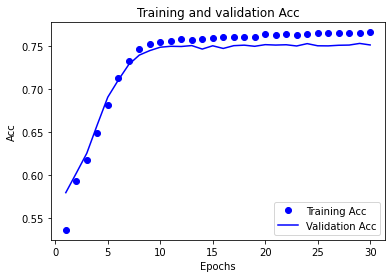

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [20]:
x_test = np.reshape(test_set.values, (len(test_set), 1, 55))
test_pred_nn = (model.predict(x_test) > 0.6).astype("int32")

563/563 [==============================] - 1s 875us/step


In [21]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      9000
           1       0.82      0.68      0.74      9000

    accuracy                           0.77     18000
   macro avg       0.77      0.77      0.76     18000
weighted avg       0.77      0.77      0.76     18000



# Trying now models that can't scale really well with data size

## K-NN Classifier


In [22]:
from sklearn.neighbors import KNeighborsClassifier
# use tqdm
import tqdm

k_list = [x for x in range(1, 25)]

knn_list = []
for k in tqdm.tqdm(k_list):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_set_small, train_label_small)
    knn_list.append(knn.score(test_set_small, test_label_small))
    
    # predictions
    prediction_train = knn.predict(train_set_small)
    prediction_test = knn.predict(test_set_small)
    
    #accuracy
    accuracy_train = metrics.accuracy_score(train_label_small, prediction_train)
    accuracy_test = metrics.accuracy_score(test_label_small, prediction_test)
    
    

100%|██████████| 19/19 [00:08<00:00,  2.22it/s]


In [23]:
# print accuracy
print(accuracy_train)
print(accuracy_test)

0.7444897959183674
0.7114285714285714


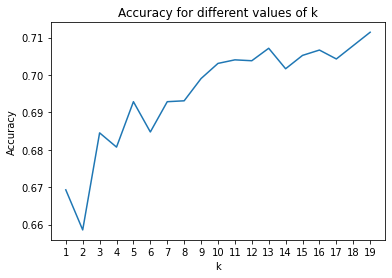

In [24]:
# plot results knn on x axis and accuracy on y axis
plt.plot(k_list, knn_list)
plt.xlabel('k')
plt.ylabel('Accuracy')
#track each k only
plt.xticks(k_list)
plt.title('Accuracy for different values of k')
plt.show()  

# SVM:

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm

#train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)
# X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)

#x_train_reshaped = train_set.reshape(train_set.shape[0], -1)


svm_classifier = SVC(kernel='linear')

svm_classifier_rbf = SVC(kernel='rbf', C=1, gamma=0.1)

svm_classifier.fit(train_set_small, train_label_small)

svm_classifier_rbf.fit(train_set_small, train_label_small)

SVC(C=1, gamma=0.1)

In [26]:
def print_svm_scores(svm_classifier):
    print("Accuracy on training set: {:.3f}".format(svm_classifier.score(train_set_small, train_label_small)))
    print("Accuracy on test set: {:.3f}".format(svm_classifier.score(test_set_small, test_label_small)))
    
    # Make predictions
    y_pred = svm_classifier.predict(test_set_small)

    # Evaluate the model
    accuracy = accuracy_score(test_label_small, y_pred)
    report = classification_report(test_label_small, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)

In [27]:
print_svm_scores(svm_classifier)

Accuracy on training set: 0.736
Accuracy on test set: 0.727
Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.66      0.71      2100
        True       0.70      0.80      0.75      2100

    accuracy                           0.73      4200
   macro avg       0.73      0.73      0.73      4200
weighted avg       0.73      0.73      0.73      4200



In [28]:
print_svm_scores(svm_classifier_rbf)

Accuracy on training set: 0.784
Accuracy on test set: 0.754
Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.81      0.77      2100
        True       0.79      0.70      0.74      2100

    accuracy                           0.75      4200
   macro avg       0.76      0.75      0.75      4200
weighted avg       0.76      0.75      0.75      4200



## Radom Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate

def build_random_forest(X, y, max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100, cv=6, print_res=True):
    clf = RandomForestClassifier(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    best_score = scores.mean()

    if print_res:
        print("RF - Fixed parameters used:")
        print(f"Max Depth: {max_depth}, Max Features: {max_features}, Min Samples Leaf: {min_samples_leaf}, n_estimators: {n_estimators}")
        print("RF - Accuracy score:")
        print(best_score)

    clf.fit(X, y)
    return best_score, clf


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_set_scaled = scaler.fit_transform(train_set_small)
best_score_rf, best_rf = build_random_forest(train_set_scaled, train_label_small)

#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))
y_pred_test = best_rf.predict(train_set_scaled)
report_scores(train_label_small, y_pred_test)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.728) total time=   2.3s
[CV] END ................................ score: (test=0.725) total time=   2.3s
[CV] END ................................ score: (test=0.733) total time=   2.3s
[CV] END ................................ score: (test=0.729) total time=   2.3s
[CV] END ................................ score: (test=0.739) total time=   2.4s
[CV] END ................................ score: (test=0.750) total time=   2.4s


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    3.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    3.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.6s finished


RF - Fixed parameters used:
Max Depth: None, Max Features: None, Min Samples Leaf: 1, n_estimators: 100
RF - Accuracy score:
0.7340808817926273
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4900
           1       0.91      0.91      0.91      4900

    accuracy                           0.91      9800
   macro avg       0.91      0.91      0.91      9800
weighted avg       0.91      0.91      0.91      9800

